In [1]:
import numpy
import pandas

from sklearn.model_selection import train_test_split
from matplotlib import pyplot

from tqdm import trange

### Hyperparameters

In [2]:
LEARNING_RATE = 0.1
SEED_VALUE = 2904

numpy.random.seed(SEED_VALUE)

### Loading Data

In [3]:
url = "heart.csv"

data = pandas.read_csv(url)

# Normalizing
data_orig = data.copy()

print(data.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


### Understanding data

Columns represent the following:-

1.  `age` - Age of the person
2.  `sex` - Gender of the person
3.  `cp` - chest pain type (4 Levels)
4.  `trestbps` - resting blood pressure
5.  `chol` - serum cholestoral in mg/dl
6.  `fbs` - fasting blood sugar > 120 mg/dl
7.  `restecg` - resting electrocardiographic results (values 0,1,2)
8.  `thalach` - maximum heart rate achieved
9.  `exang` - exercise induced angina
10. `oldpeak` -  oldpeak = ST depression induced by exercise relative to rest
11. `slope` -  the slope of the peak exercise ST segment
12. `ca` -  number of major vessels (0-3) colored by flourosopy
13. `thal` -  thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

target - presence of heart disease

In [4]:
features = data.columns[:-1].values
classes = data.iloc[:, -1].unique()

print("Features: ", features)
print("Classes:", classes)

Features:  ['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal']
Classes: [0 1]


In [5]:
m = len(features) # 13
n = 1

m, n

(13, 1)

In [6]:
# Size of data

data.shape

(1025, 14)

### Normalizing data

1. Min-Max Normalization
2. **Z-Score Normalization**
3. Just divide by Max

In [7]:
def normalize_data(X, data):
    ''' Z-Score Normalization '''
    return (X - data.mean()) / data.std()

In [8]:
feature_data = data[features]
feature_data = normalize_data(feature_data, data[features])

In [9]:
train_x, test_x, train_y, test_y = train_test_split(feature_data, data.iloc[:, -1], test_size=0.3, random_state=1)

# Converting to numpy.ndarray
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

In [10]:
train_x.shape, test_x.shape

((717, 13), (308, 13))

### Loss Function

Mean Squared Error

$E_{avg} = \frac{1}{2}~\sum_{k \in K} E_k$

In [11]:
class MSE_Loss:
    ''' Loss Function - Mean Squared Error '''
    
    def fn(D: numpy.ndarray, Y: numpy.ndarray):
        ''' MSE - Loss '''
        return .5 * numpy.sum(numpy.power(D - Y, 2), axis = 0)
        # return (1 / D.shape[0]) * numpy.sum(0.5 * numpy.sum(numpy.power(D - Y, 2), axis = 0))
    
    def deriv_fn(D: numpy.ndarray, Y: numpy.ndarray) -> numpy.ndarray:
        ''' MSE - Derivative Function'''
        return numpy.sum(D - Y, axis = 0)

### Sigmoid Activation

$\phi (x) = \frac{1}{1 + e^{-x}}$

$\phi'(x) = \phi(x)(1 - \phi(x))$

In [12]:
class Sigmoid:
    ''' Sigmoid Activation Function '''
    
    def fn(v: numpy.ndarray) -> numpy.ndarray:
        ''' Sigmoid function '''
        return 1. / ( 1. + numpy.exp(-v) )
    
    def deriv_fn(y: numpy.ndarray) -> numpy.ndarray:
        ''' Derivative of Sigmoid Function '''
        y_temp = y.astype(float)
        return y_temp * (1 - y_temp)

### Multi-layer Perceptron

In [13]:
class MLP:
    ''' Multilayer Perceptron with only 1 hidden layer '''
    
    def __init__(self, input_m: int, hidden_k: int, output_n: int):
        
        self.m = input_m
        self.k = hidden_k
        self.n = output_n
        
        self.wts_x_h = numpy.random.randn(self.m, self.k)
        self.wts_h_y = numpy.random.randn(self.k, self.n)
        
        self.bias_h = numpy.random.random((1, self.k))
        self.bias_y = numpy.random.random((1, self.n))
    
    def train(self, X: numpy.ndarray, D: numpy.ndarray, val_X: numpy.ndarray = None, val_D: numpy.ndarray = None, epochs: int = 5):
        ''' Training the dataset '''
        
        metrics = {
            "loss": [], 
            "accuracy": []
        }
        
        epoch_range = trange(epochs)
        batch_size = 1
        
        for _ in epoch_range:
            for i in range(0, X.shape[0], batch_size):
                
                x = X[i:i+batch_size]
                d = D[i:i+batch_size]
                
                # Feed forward
                y1, y2 = self.predict(x)
                
                # Backpropogation
                
                output_error = MSE_Loss.deriv_fn(d, y2)
                output_delta = output_error * Sigmoid.deriv_fn(y2)
                # Above code should be v2 instead of y2 
                # but the code is changed in sigmoid function.
                
                hidden_error = output_delta.dot(self.wts_h_y.T)
                hidden_delta = hidden_error * Sigmoid.deriv_fn(y1)
                
                delta_w_output = LEARNING_RATE * numpy.dot(y1.T, output_delta)
                delta_w_hidden = LEARNING_RATE * numpy.dot(x.T, hidden_delta)
                
                # Updating wts and bias
                self.wts_h_y = self.wts_h_y + delta_w_output
                self.wts_x_h = self.wts_x_h + delta_w_hidden

                self.bias_y = self.bias_y + numpy.sum(delta_w_output, axis = 0)
                self.bias_h = self.bias_h + numpy.sum(delta_w_hidden, axis = 0)
            
            if val_X is not None and val_D is not None:
                _, y_pred = self.predict(val_X)
                metrics['loss'].append(MSE_Loss.fn(val_D, y_pred))
                metrics['accuracy'].append(MLP.accuracy(val_D, y_pred))
       
        return metrics
        
    def accuracy(D: numpy.ndarray, Y: numpy.ndarray):
        ''' Accuracy (tightly coupled) '''
        Y_temp = (Y > 0.5).astype(int)
        return numpy.sum(D == Y_temp) / D.shape[0]        
            
    def predict(self, X: numpy.ndarray):
        ''' Prediction of data '''
        
        v1 = X.dot(self.wts_x_h) + self.bias_h
        y1 = Sigmoid.fn(v1)
        
        v2 = y1.dot(self.wts_h_y) + self.bias_y
        y2 = Sigmoid.fn(v2)
        
        return [y1, y2]
    

In [14]:
model = MLP(m, 10, n)

train_y = train_y[:, None]
test_y = test_y[:, None]

metrics = model.train(train_x, train_y, test_x, test_y, 250)

100%|██████████| 250/250 [00:08<00:00, 30.12it/s]


In [15]:
_, pred_y = model.predict(test_x)
print(test_y[:10].T)
print((pred_y[:10].T > 0.5).astype(int))

[[0 1 1 0 0 1 1 1 0 1]]
[[0 1 1 1 0 1 1 1 0 1]]


### Metrics

We plot the available plots - Loss and Accuracy over epochs. 

This gives us an idea of how the model has performed and how is it learning parameters. 

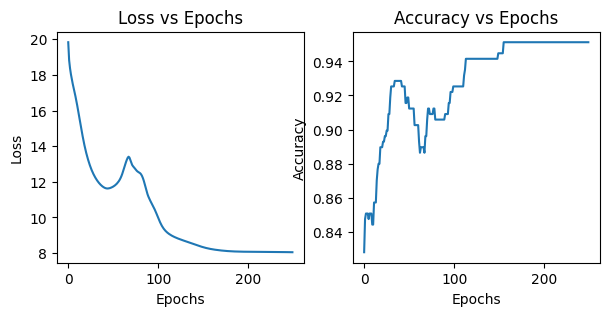

In [18]:
_, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(7, 3))

ax1.plot(metrics['loss'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs Epochs")

ax2.plot(metrics['accuracy'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs Epochs")

pyplot.show()

### Testing

In [17]:
y_pred = model.predict(test_x)

print("Sample of Desired Output and Actual Output:")

print(f"Desired Output : {test_y.T[0][:10]}")
print(f"Actual Output : {(y_pred[-1].T[0] > .5).astype(int)[:10]}")
print()

test_accuracy = MLP.accuracy(test_y, y_pred[-1]) 

print(f"Accuracy on Test Dataset : {test_accuracy}")
print()

if test_accuracy > .95: print("Very Good Model")
elif test_accuracy > .9: print("Good Model")
elif test_accuracy > .8: print("Decent Model")
else: print("Not a good model")

Sample of Desired Output and Actual Output:
Desired Output : [0 1 1 0 0 1 1 1 0 1]
Actual Output : [0 1 1 1 0 1 1 1 0 1]

Accuracy on Test Dataset : 0.9512987012987013

Very Good Model
